In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import ElasticNet, Lasso, Ridge
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score

In [3]:
# 读取已处理好的数据
flow = pd.read_csv('信息流数据_v2.csv',encoding='gbk') # 读ansi格式时会出错，需要加gbk编码

In [4]:
# 划分feature和target
X = flow.drop(['点击ROI'],axis = 1)
y = flow['点击ROI']

pcbd    0.51401
byhe    0.38473
mxwl    0.10126
Name: 品牌名称, dtype: float64

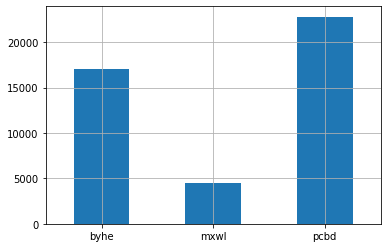

In [5]:
# 品牌分布检验
X['品牌名称'].value_counts().sort_index().plot.bar(grid = True,rot= 0) 
X['品牌名称'].value_counts()/ len(X['品牌名称'])

In [6]:
# 按品牌分层划分train和test
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(X,X['品牌名称']):
    print("Train Index:",train_index,",Test Index:",test_index)
    X_train,X_test=X.loc[train_index],X.loc[test_index]
    y_train,y_test=y.loc[train_index],y.loc[test_index]

Train Index: [27754 32923  9682 ... 29080 32387 25716] ,Test Index: [32072 23319 41782 ... 32481 30942 41419]


In [7]:
# 检验是否分层抽样成功
X_test['品牌名称'].value_counts()/ len(X_test['品牌名称'])
X_train['品牌名称'].value_counts()/ len(X_train['品牌名称'])

pcbd    0.514005
byhe    0.384722
mxwl    0.101274
Name: 品牌名称, dtype: float64

In [8]:
# 删除品牌名称变量
X_test.drop(['品牌名称'],axis=1,inplace = True)
X_train.drop(['品牌名称'],axis=1,inplace = True)

In [9]:
# 定义评价函数,五折交叉验证
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse_score= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    print(rmse_score)
    print(rmse_score.mean())
    print(rmse_score.std())

In [9]:
# 因为加入了L1L2惩罚项，需要进行缩放。有dummy，要对特征进行归一化
scaler = MinMaxScaler()
X_1=scaler.fit_transform(X_train)
X_2=scaler.fit_transform(X_test)
X_train = pd.DataFrame(X_1, columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(X_2, columns=X_test.columns,index=X_test.index)

# LR调参

In [17]:
# Ridge调参
cv_params = {'alpha': [0,0.005,0.01,0.015,0.02,0.025]}
other_params = {'random_state':1,'alpha':0.005}
ridge_model = Ridge(**other_params)
optimized_ridge = GridSearchCV(estimator=ridge_model, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1) #用所有处理器
optimized_ridge.fit(X_train, y_train)
evalute_result = optimized_ridge.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_ridge.best_params_))
print('最佳模型得分:{0}'.format(optimized_ridge.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.0s finished


每轮迭代运行结果:{'mean_fit_time': array([14.7597199 ,  3.13014321,  3.25246744,  3.50188322,  3.64898868,
        2.96204329]), 'std_fit_time': array([0.1611983 , 0.44603602, 0.52674781, 0.31263891, 0.15954811,
       0.49220647]), 'mean_score_time': array([0.01747131, 0.07132807, 0.05884705, 0.07969656, 0.05857821,
       0.04773507]), 'std_score_time': array([0.00265523, 0.01110462, 0.00973398, 0.01799332, 0.00416132,
       0.00874441]), 'param_alpha': masked_array(data=[0, 0.005, 0.01, 0.015, 0.02, 0.025],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0}, {'alpha': 0.005}, {'alpha': 0.01}, {'alpha': 0.015}, {'alpha': 0.02}, {'alpha': 0.025}], 'split0_test_score': array([-188.85679389, -148.52038441, -148.51641636, -148.55855808,
       -148.62760994, -148.719023  ]), 'split1_test_score': array([-165.88309832, -160.01283728, -159.89532562, -159.8253922 ,
       -159.78529566, -159.76820182]), 'split2_tes

In [19]:
# 弹性网络调参：从lasso的alpha最佳参数为0以及弹性网络L1ration为0，可知仅用ridge
cv_params = {'l1_ratio': [0,0.05]}
other_params = {'random_state':3,
               'alpha':0.01,
               'l1_ratio':0}
ENet_model = ElasticNet(**other_params)
optimized_en = GridSearchCV(estimator=ENet_model, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1) #用所有处理器
optimized_en.fit(X_train, y_train)
evalute_result = optimized_en.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_en.best_params_))
print('最佳模型得分:{0}'.format(optimized_en.best_score_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   50.3s finished


每轮迭代运行结果:{'mean_fit_time': array([49.70595994,  8.28310122]), 'std_fit_time': array([0.41943755, 0.16936027]), 'mean_score_time': array([0.01550183, 0.03713341]), 'std_score_time': array([0.00627151, 0.01234856]), 'param_l1_ratio': masked_array(data=[0, 0.05],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'l1_ratio': 0}, {'l1_ratio': 0.05}], 'split0_test_score': array([-364.77642439, -365.42220302]), 'split1_test_score': array([-368.56387772, -368.95645868]), 'split2_test_score': array([-374.9278781 , -375.58703469]), 'split3_test_score': array([-453.45160926, -453.66200095]), 'split4_test_score': array([-443.44922224, -443.58081557]), 'mean_test_score': array([-401.03113008, -401.43904367]), 'std_test_score': array([38.97921135, 38.79075475]), 'rank_test_score': array([1, 2])}
参数的最佳取值：{'l1_ratio': 0}
最佳模型得分:-401.03113007925896


C:\Users\Sunny\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462993342335.77826, tolerance: 94249394.37711519
  positive)


# XGboost调参

In [21]:
# n_estimators
cv_params = {'n_estimators': [400,600,800,1000]}
other_params = {'learning_rate': 0.1,'n_estimators':1000, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
xgbt_model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=xgbt_model, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 12.7min finished


每轮迭代运行结果:{'mean_fit_time': array([ 85.34924264, 129.27814608, 168.9499691 , 192.73531337]), 'std_fit_time': array([ 0.51830045,  2.96215327,  2.31308182, 18.43206032]), 'mean_score_time': array([0.16360779, 0.1724206 , 0.19425154, 0.17321444]), 'std_score_time': array([0.01999828, 0.00795321, 0.01441607, 0.03809285]), 'param_n_estimators': masked_array(data=[400, 600, 800, 1000],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 400}, {'n_estimators': 600}, {'n_estimators': 800}, {'n_estimators': 1000}], 'split0_test_score': array([-22.15863266, -21.01184454, -20.67275773, -20.47937188]), 'split1_test_score': array([-38.15036172, -36.97427719, -36.48122667, -36.20191694]), 'split2_test_score': array([-24.16124237, -23.2066368 , -22.86803486, -22.61838286]), 'split3_test_score': array([-54.60375418, -53.86734787, -53.5598982 , -53.34207551]), 'split4_test_score': array([-35.22195172, -34.5850254 , -34.25917565, 

In [22]:
# min_child_weight以及max_depth
cv_params = {'min_child_weight': [1,2,3],
             'max_depth':[3,4,5]
            }
other_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
xgbt_model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=xgbt_model, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 33.2min finished


每轮迭代运行结果:{'mean_fit_time': array([139.29149041, 138.35877662, 137.92514887, 174.55571442,
       172.42571664, 174.00500979, 207.17541552, 208.21526232,
       186.70233698]), 'std_fit_time': array([ 1.16613797,  2.94293007,  1.04726039,  2.02234249,  1.61969813,
        1.60502263,  4.4849408 ,  5.84193399, 30.51327684]), 'mean_score_time': array([0.17746916, 0.16815486, 0.1715982 , 0.19933472, 0.19490919,
       0.18819857, 0.200665  , 0.21064501, 0.17728906]), 'std_score_time': array([0.00699877, 0.0064927 , 0.00661925, 0.01062338, 0.003114  ,
       0.00792433, 0.01127655, 0.00432268, 0.05157204]), 'param_max_depth': masked_array(data=[3, 3, 3, 4, 4, 4, 5, 5, 5],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 2, 3, 1, 2, 3, 1, 2, 3],
             mask=[False, False, False, False, False, False, False, False,
                   False

In [25]:
# gamma
cv_params = {'gamma': [0.3,0.4,0.5]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
xgbt_model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=xgbt_model, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 13.3min finished


每轮迭代运行结果:{'mean_fit_time': array([207.58898644, 207.73377175, 185.58153558]), 'std_fit_time': array([ 1.53423503,  1.26056968, 20.08532512]), 'mean_score_time': array([0.21001062, 0.21030397, 0.16181135]), 'std_score_time': array([0.0053589 , 0.01097637, 0.03858453]), 'param_gamma': masked_array(data=[0.3, 0.4, 0.5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.3}, {'gamma': 0.4}, {'gamma': 0.5}], 'split0_test_score': array([-20.44938678, -20.45349333, -20.45702547]), 'split1_test_score': array([-36.2078135 , -36.20781946, -36.20133561]), 'split2_test_score': array([-22.60777326, -22.63752593, -22.62216459]), 'split3_test_score': array([-53.36011813, -53.36228141, -53.36818081]), 'split4_test_score': array([-34.05662783, -34.05987288, -34.0512643 ]), 'mean_test_score': array([-33.33575936, -33.34361435, -33.33940975]), 'std_test_score': array([11.75477727, 11.74922672, 11.75284245]), 'rank_test_score': array([1, 3, 2]

In [27]:
# subsample以及colsample_bytree
cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight':1 , 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 1}
xgbt_model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=xgbt_model, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 32.6min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 66.7min finished


每轮迭代运行结果:{'mean_fit_time': array([178.2487432 , 166.34574032, 139.79408011, 135.15635433,
       174.2884583 , 187.61131892, 204.14702597, 198.03668776,
       230.85568528, 219.36005759, 210.08292432, 202.29232812,
       250.70405207, 241.16494608, 232.80079432, 222.00068102]), 'std_fit_time': array([ 3.50107234, 16.84508581,  2.46097386,  1.00541401,  2.77767437,
       18.21773269,  2.90414242,  0.75056234,  2.34496854,  1.77730074,
        1.41182397,  1.06904399,  2.3786543 ,  2.80067258,  1.63630829,
        1.34221976]), 'mean_score_time': array([0.20080094, 0.18413272, 0.18593106, 0.18566132, 0.19462366,
       0.2213325 , 0.24220295, 0.22752962, 0.2285049 , 0.21391735,
       0.21190376, 0.21563983, 0.20917239, 0.22175884, 0.21098833,
       0.16592546]), 'std_score_time': array([0.00546966, 0.01989066, 0.00376145, 0.00295519, 0.02142507,
       0.02285818, 0.01259505, 0.01851963, 0.01687422, 0.0049228 ,
       0.00335434, 0.00464494, 0.00552729, 0.01643412, 0.0013561 ,
     

In [29]:
# reg_alpha以及reg_lambda
cv_params = {'reg_alpha': [0.05, 0.1, 1], 'reg_lambda': [0.05, 0.1, 1]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 1}
xgbt_model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=xgbt_model, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 42.0min finished


每轮迭代运行结果:{'mean_fit_time': array([876.00422244, 881.42611313, 879.78324113, 862.82025042,
       861.50086112, 886.78798389, 810.69334521, 752.73020787,
       728.62580962]), 'std_fit_time': array([16.20118683, 12.36373508, 12.67717026, 15.31175171,  9.86825371,
        3.69678806, 65.9742386 ,  1.1626766 ,  2.983741  ]), 'mean_score_time': array([0.83635392, 0.79951105, 0.82110496, 0.81598678, 0.83390903,
       0.86401863, 0.67639465, 0.58494411, 0.39222412]), 'std_score_time': array([0.05930709, 0.07312373, 0.04171572, 0.06972256, 0.04308848,
       0.04331178, 0.10242749, 0.05755269, 0.05253595]), 'param_reg_alpha': masked_array(data=[0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 1, 1, 1],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_reg_lambda': masked_array(data=[0.05, 0.1, 1, 0.05, 0.1, 1, 0.05, 0.1, 1],
             mask=[False, False, False, False, False, False, False, False,


In [30]:
# learning_rate
cv_params = {'learning_rate': [0.01, 0.05, 0.07]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}
xgbt_model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=xgbt_model, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 711.9min finished


每轮迭代运行结果:{'mean_fit_time': array([42686.80253763, 42686.49226079, 42689.06389785]), 'std_fit_time': array([11.76035469,  6.66485416,  5.30885093]), 'mean_score_time': array([0.58742361, 0.5881937 , 0.56834245]), 'std_score_time': array([0.20288569, 0.1198824 , 0.0707257 ]), 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.07],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.01}, {'learning_rate': 0.05}, {'learning_rate': 0.07}], 'split0_test_score': array([-24.89983747, -16.63693954, -17.43823936]), 'split1_test_score': array([-31.20741623, -22.74538812, -23.63850515]), 'split2_test_score': array([-23.3113097 , -15.70527526, -17.55575634]), 'split3_test_score': array([-85.0145382 , -57.42816314, -61.71273417]), 'split4_test_score': array([-49.90358832, -34.02775571, -33.41415197]), 'mean_test_score': array([-42.86595207, -29.30777901, -30.75092995]), 'std_test_score': array([23.09550365, 15.50245536, 16.53

# lightGBM调参

In [10]:
parameters = {
              'max_depth': [15, 20, 25],
              'learning_rate': [0.01, 0.02, 0.05],
              'feature_fraction': [0.6, 0.7, 0.8],
              'bagging_fraction': [0.6, 0.7, 0.8],
              'bagging_freq': [2, 4, 5],
}
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,seed = 0,max_depth = 5
                )
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='neg_mean_absolute_error', cv=5,n_jobs=-1)
gsearch.fit(X_train, y_train)
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Best score: -177.019
Best parameters set:
	bagging_fraction: 0.8
	bagging_freq: 2
	feature_fraction: 0.8
	learning_rate: 0.05
	max_depth: 15


# 确定单模型参数

In [14]:
# 最终模型参数
# lr:lasso,ridge,ENet(L1 drop)
ridge_model  = Ridge(alpha=0.01, random_state=1)
# GBDT:xgboost,lgb
other_params = {'learning_rate': 0.05, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}
xgbt_model = xgb.XGBRegressor(colsample_bytree=0.9,
                              gamma=0.3,
                              learning_rate=0.05,
                              max_depth=5,
                              min_child_weight=1,
                              n_estimators=1000,
                              reg_alpha=1,
                              reg_lambda=1,
                              subsample=0.8,
                              nthread = -1,
                              silent =1,
                              seed = 0)
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 2, feature_fraction = 0.8,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,seed = 0,max_depth = 15
                )

# stacking

In [32]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
    # train clones base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        # 第一个循环，训练模型。第二个循环，验证
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
        # Now train the cloned meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
        # Do the predictions of all base models on the text data and use the averaged prediction as
        # meta-feature for the final prediction which id done by meta-model
   # 这是第二个阶段， 将第一阶段输出的值，当做特征，输入到第二阶段
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return  self.meta_model_.predict(meta_features)
    
stacked_averaged_models = StackingAveragedModels(base_models = (xgbt_model,gbm),
                                                 meta_model =ridge_model )

# 最终预测

In [43]:
# stackedregressor
stacked_averaged_models.fit(X_train, y_train)
stacked_pred = stacked_averaged_models.predict(X_test)
stacked_train_pred = stacked_averaged_models.predict(X_train)
print('train_MAE:{0}'.format(mean_absolute_error(y_train,stacked_train_pred)))
print('test_MAE:{0}'.format(mean_absolute_error(y_test,stacked_pred)))

[12:20:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:21:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:22:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

In [44]:
# ridge
ridge_model.fit(X_train, y_train)
ridge_model_pred = ridge_model.predict(X_test)
ridge_train_pred = ridge_model.predict(X_train)
print('train_MAE:{0}'.format(mean_absolute_error(y_train,ridge_train_pred)))
print('test_MAE:{0}'.format(mean_absolute_error(y_test,ridge_model_pred)))

train_MAE:152.7744366608531
test_MAE:622.3481966417827


In [45]:
# xgbt
xgbt_model.fit(X_train, y_train)
xgbt_model_pred = xgbt_model.predict(X_test)
xgbt_train_pred = xgbt_model.predict(X_train)
print('train_MAE:{0}'.format(mean_absolute_error(y_train,xgbt_train_pred)))
print('test_MAE:{0}'.format(mean_absolute_error(y_test,xgbt_model_pred)))

[12:30:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


train_MAE:2.464622926222466
test_MAE:433.1148549092527


In [46]:
# lgbm
gbm.fit(X_train, y_train)
gbm_pred = gbm.predict(X_test)
gbm_train_pred = gbm.predict(X_train)
print('train_MAE:{0}'.format(mean_absolute_error(y_train,gbm_train_pred)))
print('test_MAE:{0}'.format(mean_absolute_error(y_test,gbm_pred)))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
train_MAE:106.94344780063308
test_MAE:202.36685960236974
